# NMR Echo Train processing and creation of an NMR log in Real-Time:

This Jupyter Notebook uses the existing MRIL T2 bin porosities to create an NMR log echo train with introduced noise that we will then be used for the T2 inversion. 

This T2 inversion method was developed in collaboration with chatGPT which has become quite popular lately, so I decided to experiment with using this AI tool to perform this NMR log T2 inversion using the SciPy optimization library in Python with Tikhonov regularization, which incorporates a penalty term based on the sum of the squared parameters. Although the initial code provided by ChatGPT required some fine-tuning, it was a great starting point.

The repository on GitHub also includes a complete Geolog project with Geolog python loglans to complete the same process.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Sep  8 12:33:54 2020

@author: craig
"""
%matplotlib inline
#%matplotlib tk

#from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Read in NMR log and T2 bin data used to create the echo train in this instance:

In [2]:
#df = pd.read_csv('nmr.csv',index_col=0)
df = pd.read_csv('nmr.csv')

print(df.head())

    Depth   MPHI      P1      P2      P3      P4      P5     P6      P7  \
0  7177.0  3.294  0.7960  0.6230  0.1180  0.0130  0.0160  0.172  0.5560   
1  7177.5  3.002  0.3010  0.3500  0.2220  0.1540  0.2040  0.392  0.6140   
2  7178.0  3.289  0.0620  0.2170  0.3430  0.3800  0.4260  0.528  0.6300   
3  7178.5  4.568  0.0480  0.3030  0.6280  0.7910  0.7770  0.715  0.6670   
4  7179.0  5.397  0.1835  0.3435  0.6465  0.9735  1.0485  0.902  0.7175   

       P8   MFFI    MBVI  
0  0.9980  1.756  1.5370  
1  0.7650  2.129  0.8730  
2  0.7020  2.668  0.6220  
3  0.6390  3.590  0.9790  
4  0.5825  4.224  1.1735  


## Define the level spacing, number of levels to stack and random noise to introduce into the echo trains:

In [3]:
'''
    ---------------------------------------------------------------------------
    This is where we want to stack the data for a less noisy echotrain
    
    Set Level Spacing, Stacking levels and Noise below
      
            *** Stack_levels from 1 (no stacking) to 9 stacked levels *** 
    ---------------------------------------------------------------------------
'''
level_spacing = .5  # well level spacing and this model works best on 0.5 data???
stack_levels  = 3   # odd numbers are geat, even changes level spacing in new depth offset of 0.25 ' 
noise         = 1.5 # in porosity units
'''
    ---------------------------------------------------------------------------
             *** Stack_levels from 1 (no stacking) to 9 stacked levels *** 
    ---------------------------------------------------------------------------
'''

T2 =[2,4,8,16,32,64,128,256,512,1024,2048]


# Create Echo Trains and then use SciPy Optimization with Regularization for the T2 inversion:

## The parameter **lambda_** determines the strength of the regularization. 
### 1) A **smaller value of lambda_ will result in a stronger regularization** and a simpler solution, 
### 2) while a **larger value of lambda_ will result in a weaker regularization** and a more complex solution. 

#### You can adjust the value of lambda_ to find a good balance between fitting the data and preventing overfitting.

##### Allow for you to choose between SciPy Optimization or SciPy Curve_fit methods. 


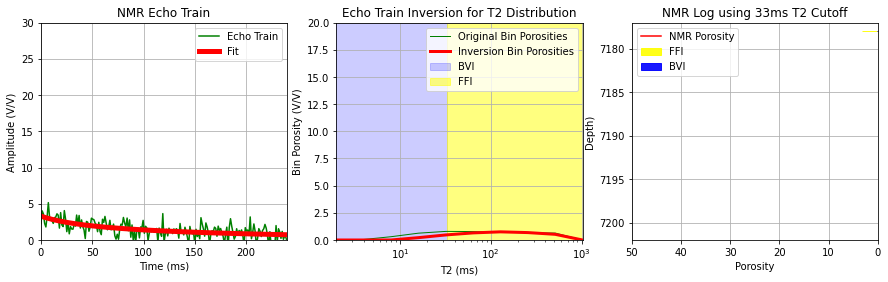

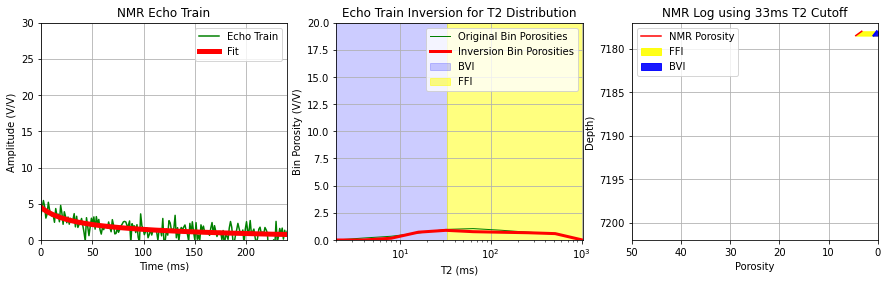

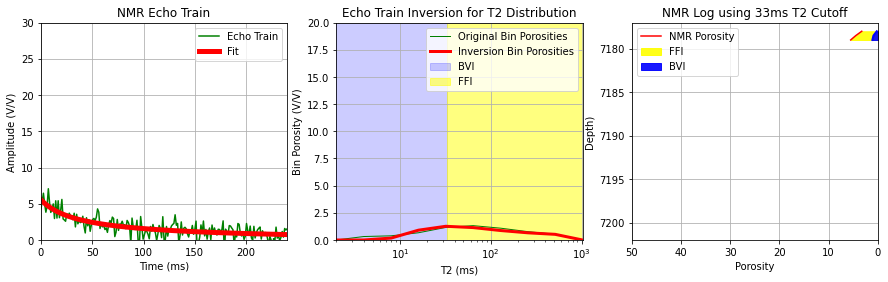

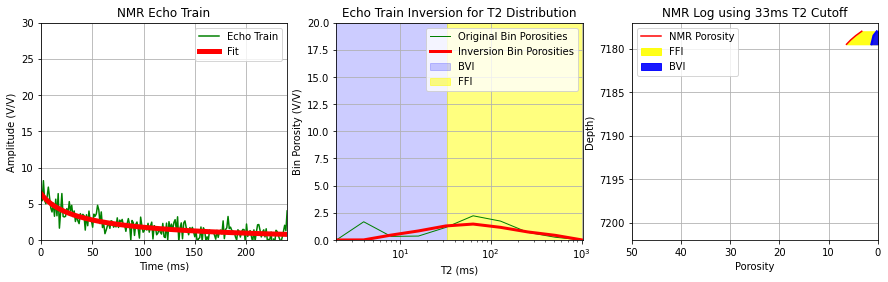

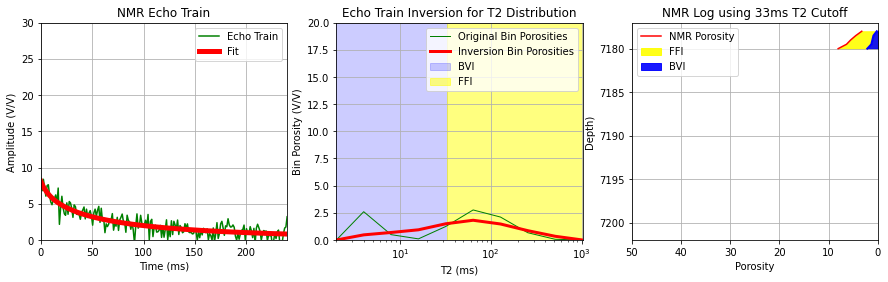

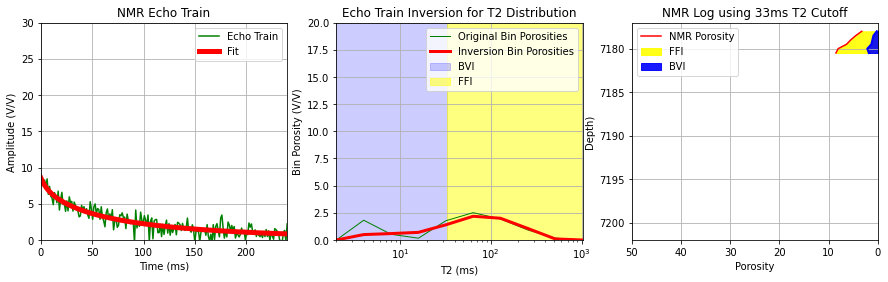

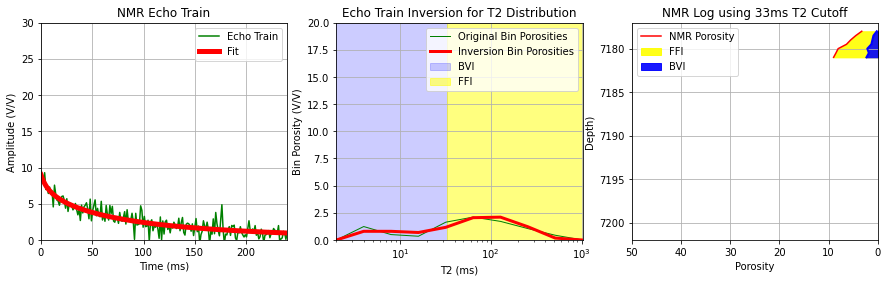

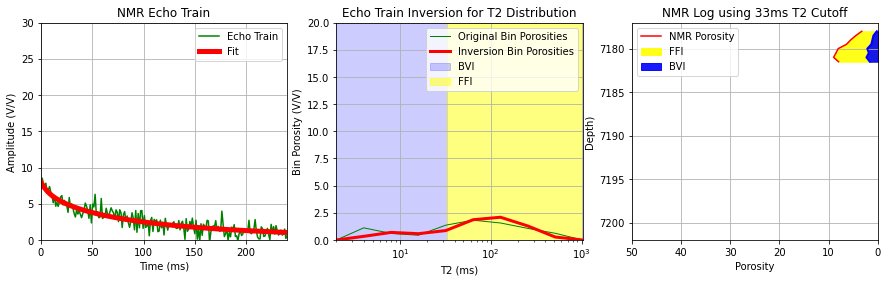

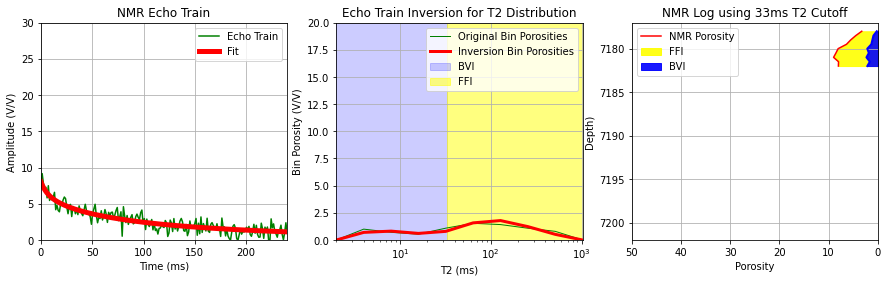

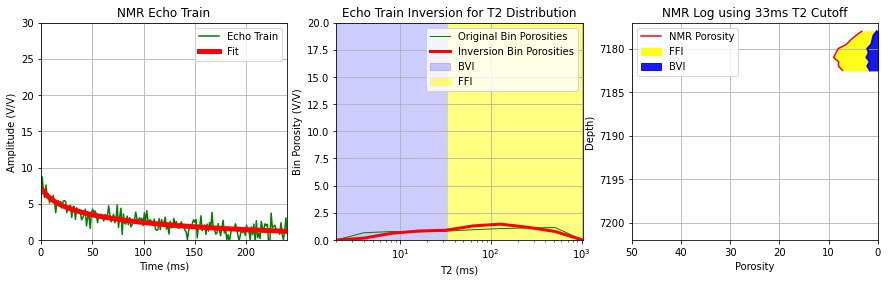

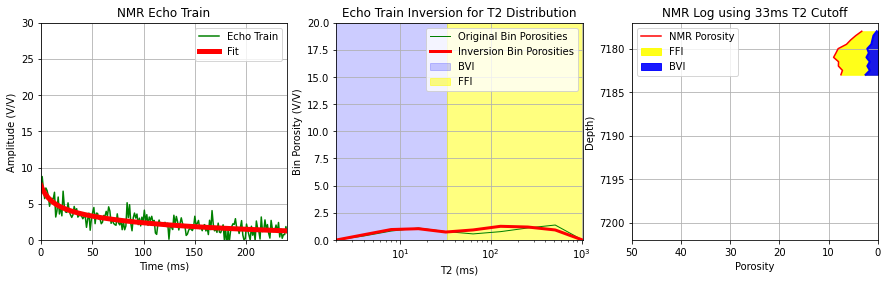

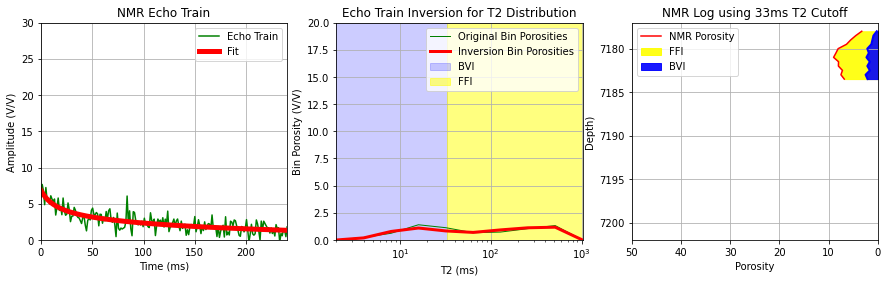

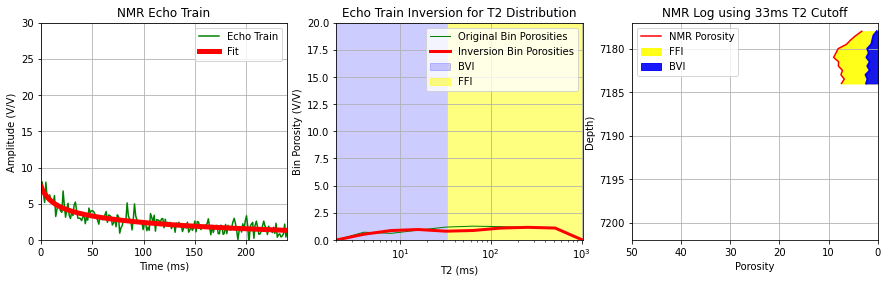

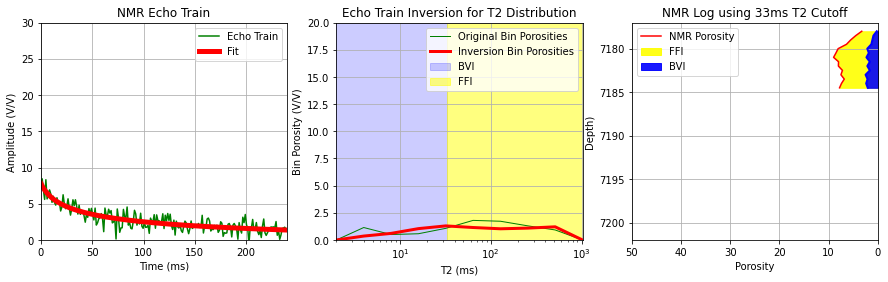

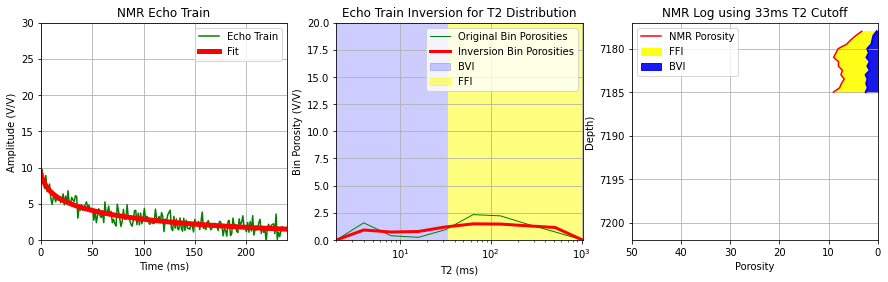

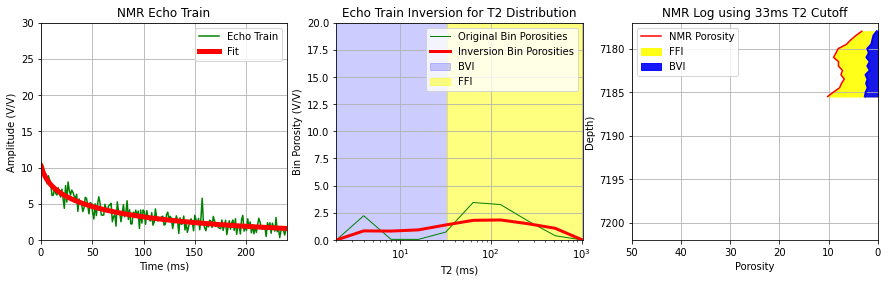

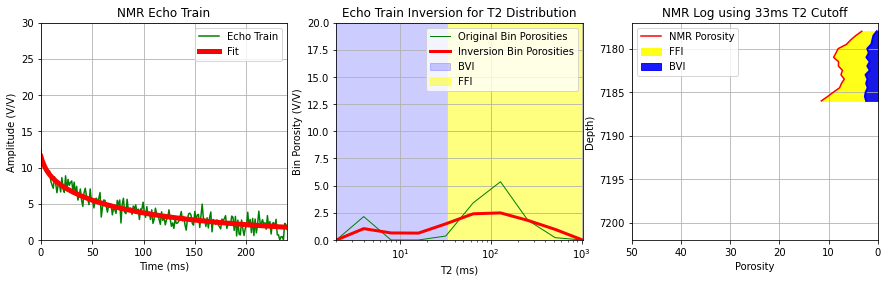

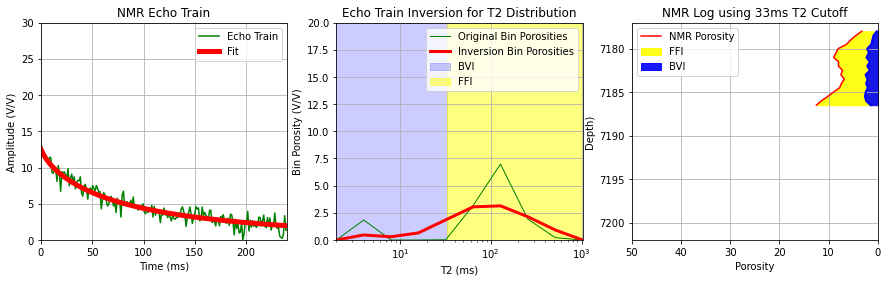

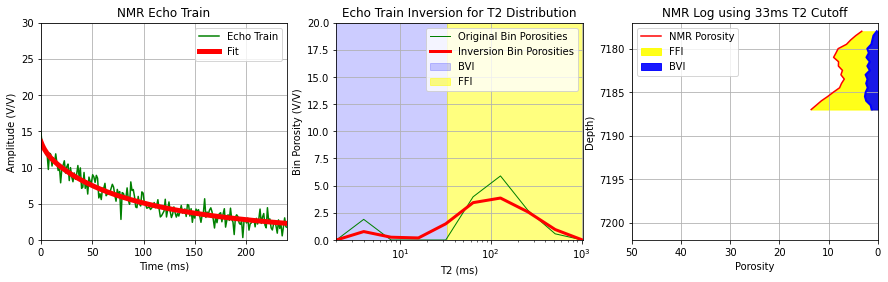

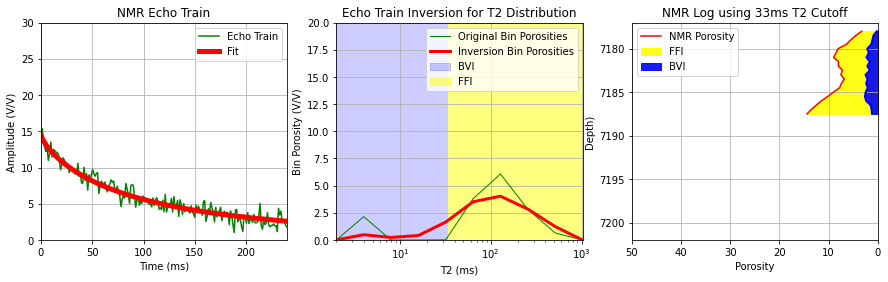

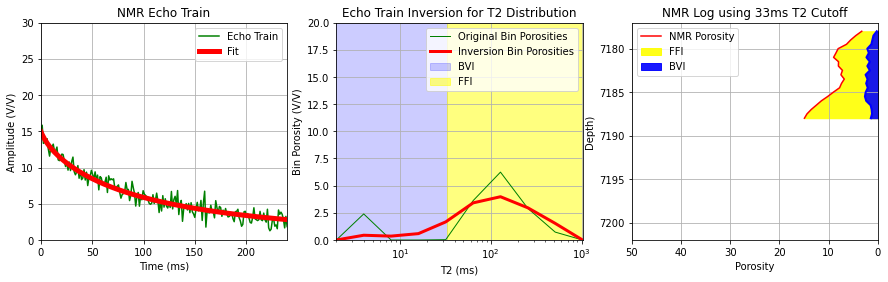

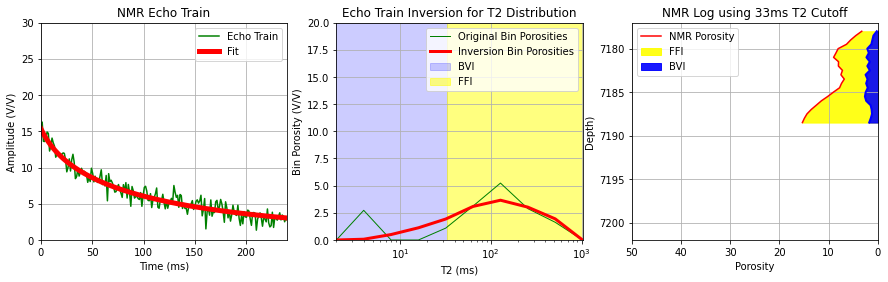

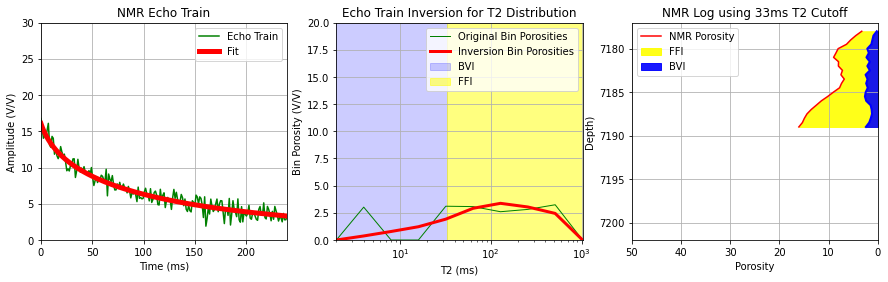

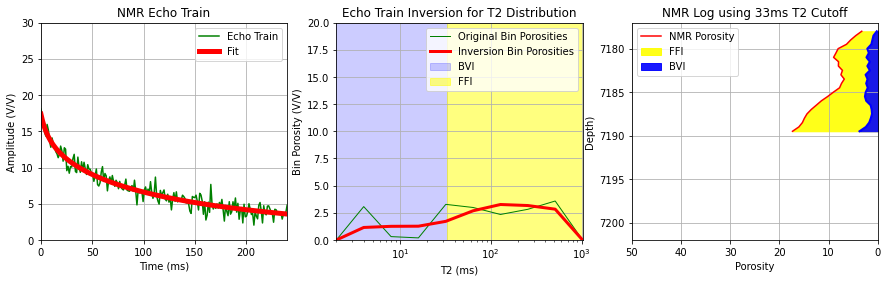

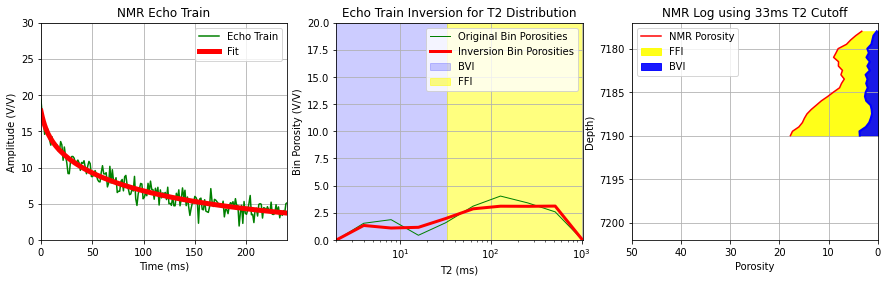

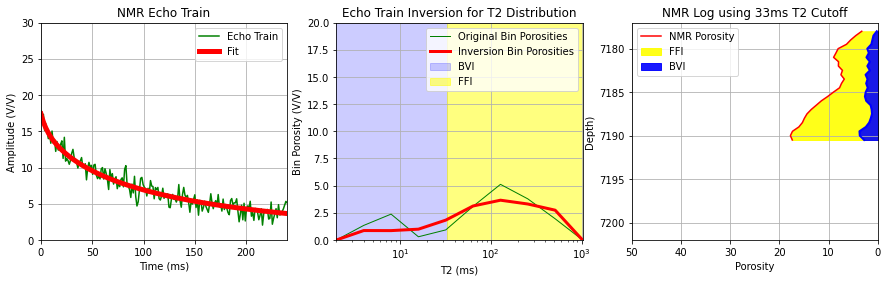

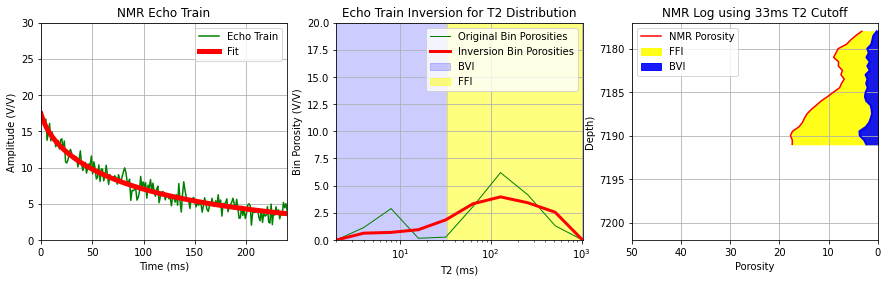

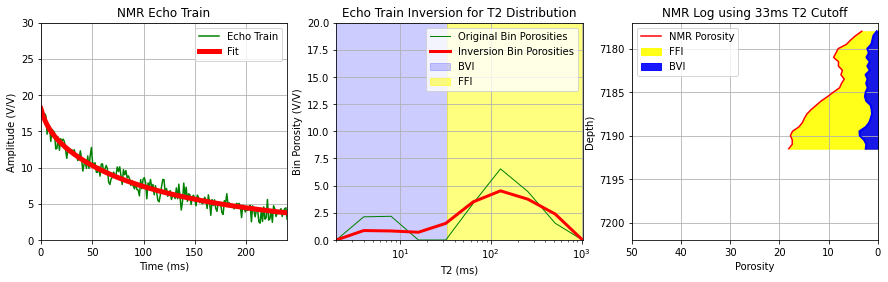

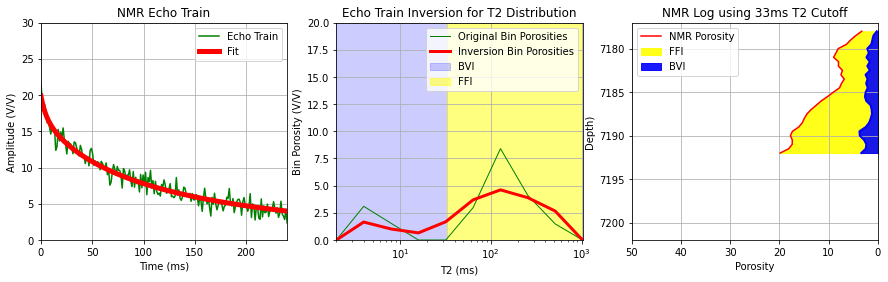

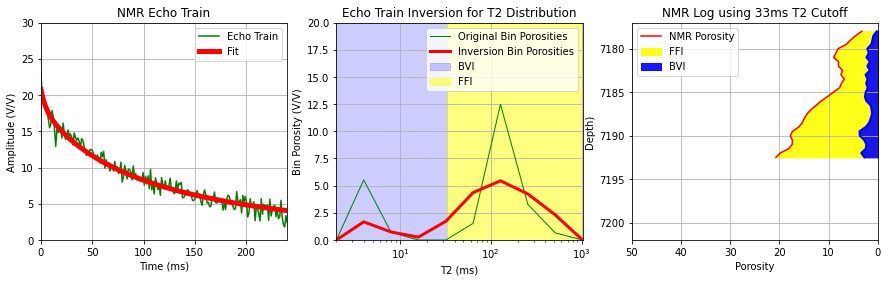

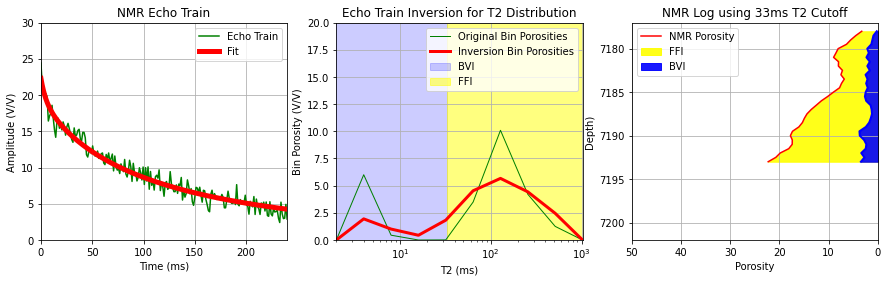

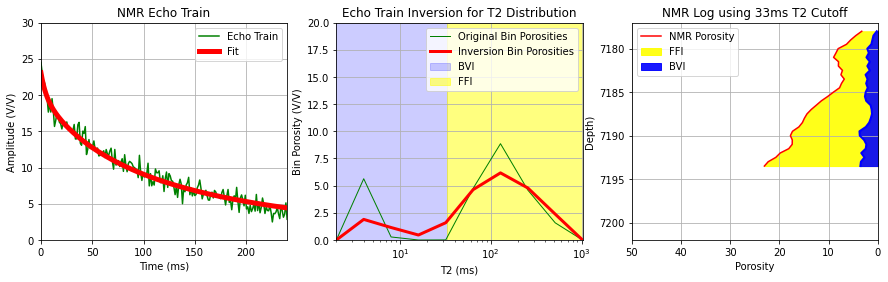

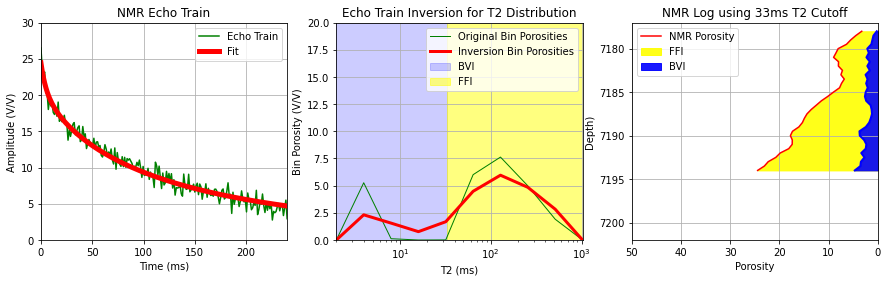

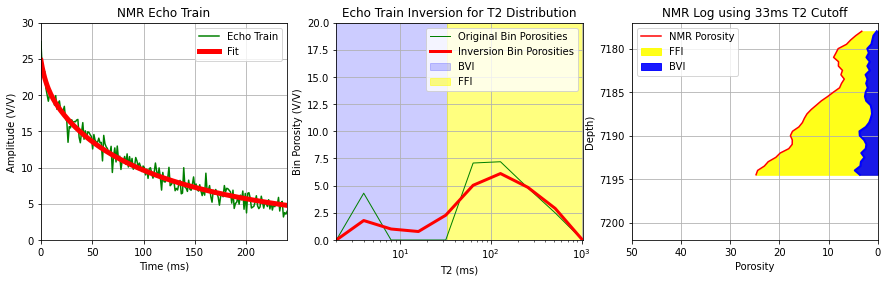

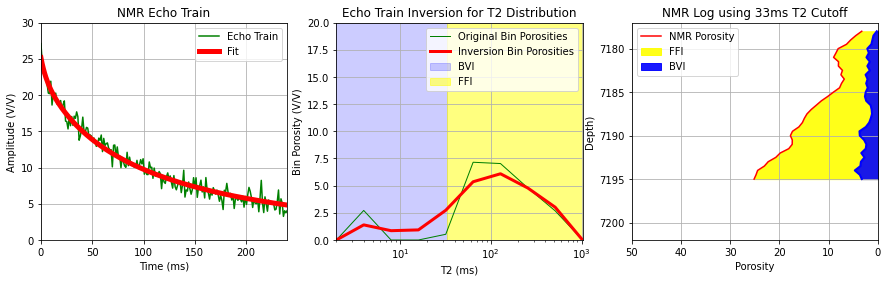

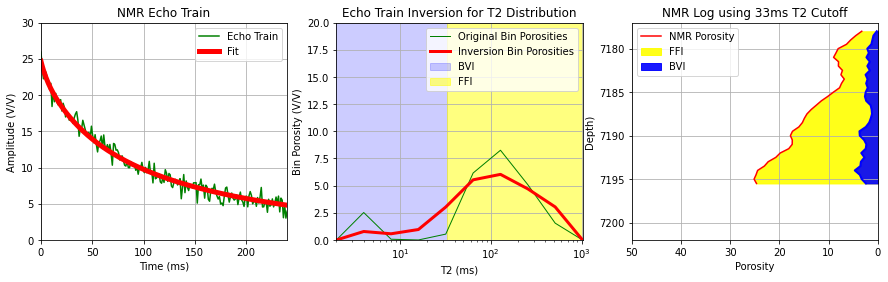

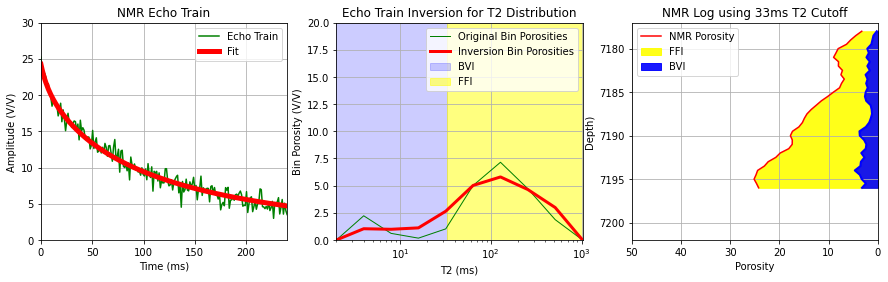

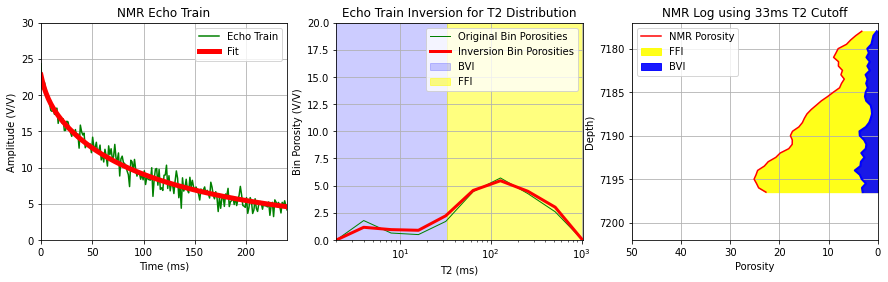

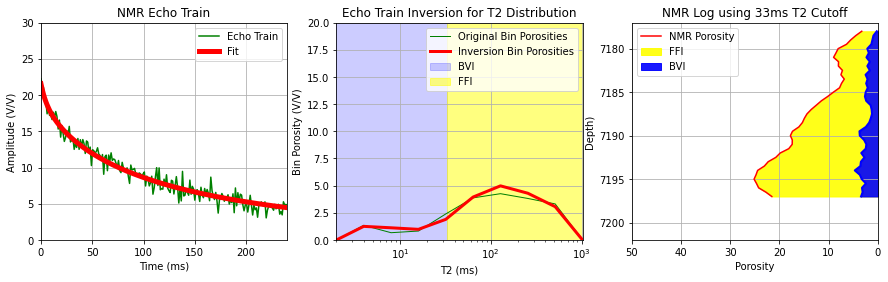

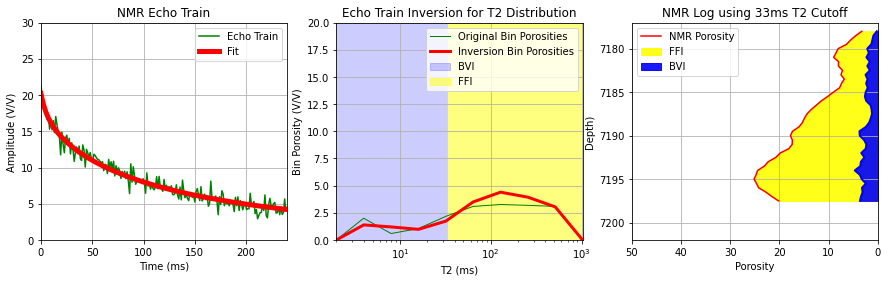

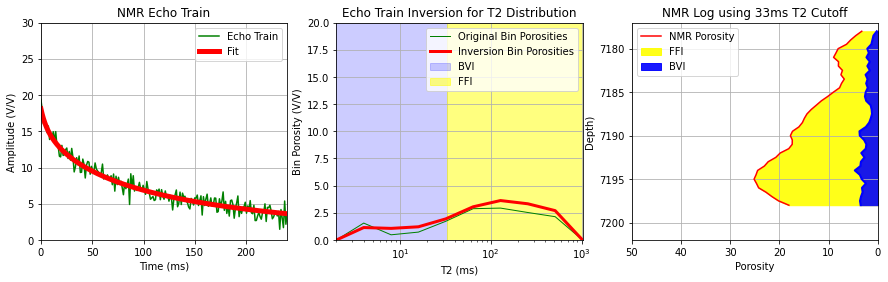

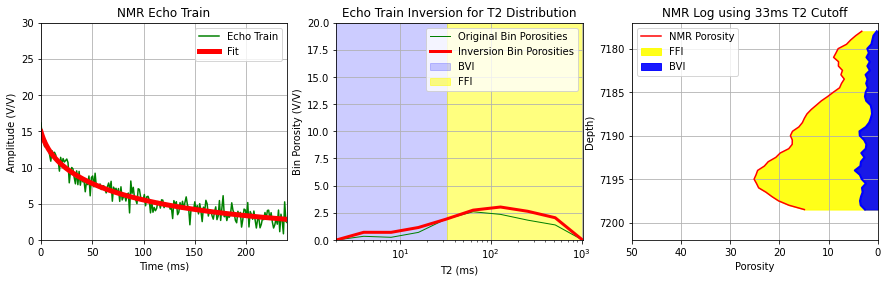

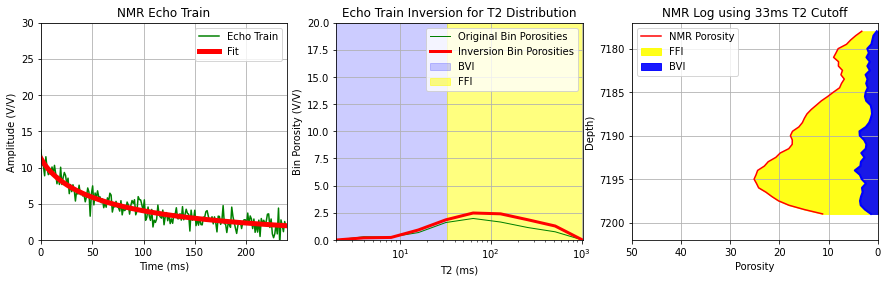

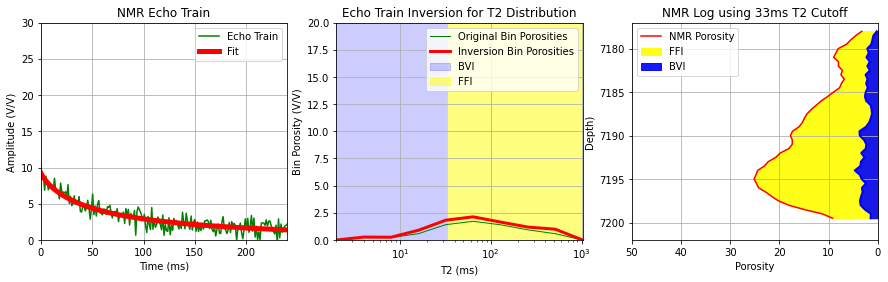

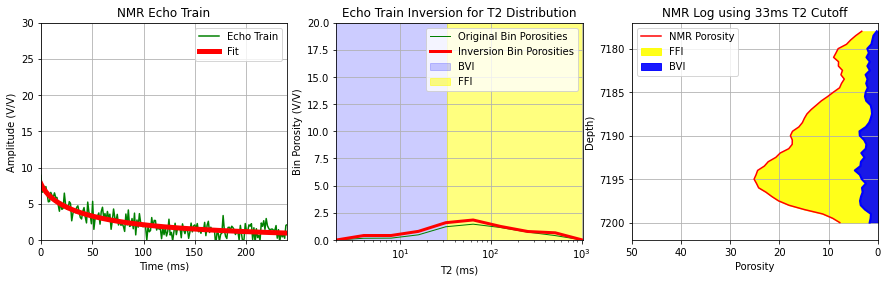

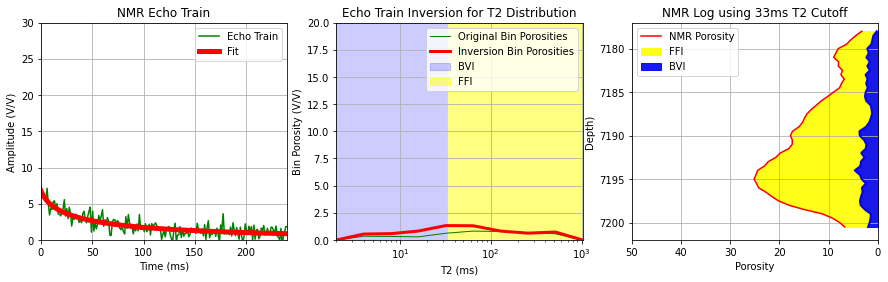

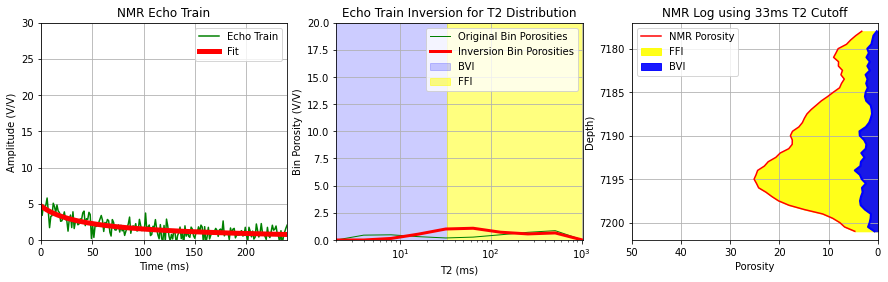

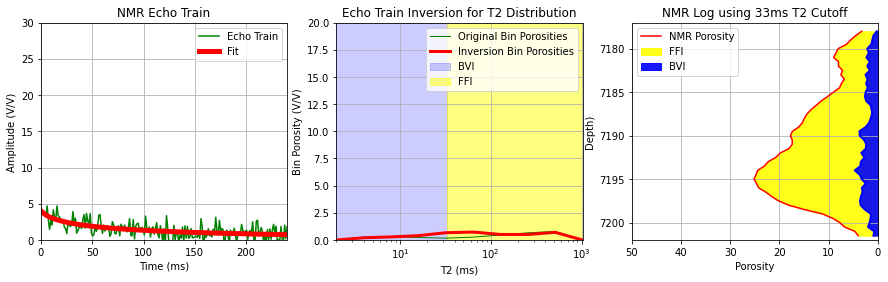

In [4]:
from scipy.optimize import minimize
from scipy.optimize import curve_fit

'''
Do you want to use SciPy Optimization with regularization or SciPy curve_fit?
'''
method = []
method = 'OPT'
#method = 'Curve_fit'



def func(x,p1,p2,p3,p4,p5,p6,p7,p8):
    return (p1*np.exp(-x/4)+p2*np.exp(-x/8)+p3*np.exp(-x/16)+p4*np.exp(-x/32)+p5*np.exp(-x/64)+p6*np.exp(-x/128)+p7*np.exp(-x/256)+p8*np.exp(-x/512))


def obj_func(params, x, y, lambda_):
    p1, p2, p3, p4, p5, p6, p7, p8 = params
    residuals = y - func(x, p1, p2, p3, p4, p5, p6, p7, p8)
    regularization = lambda_ * (p1**2 + p2**2 + p3**2 + p4**2 + p5**2 + p6**2 + p7**2 + p8**2)
    return np.sum(residuals**2) + regularization


deptharray=[]
mphiarray=[]    
mbviarray=[]
mffiarray=[]    
echo=[]
ystack=[]
T21=[]
T22 = []
#ystack2=[]
#ystackecho=[]

for index, row in df.iterrows():
    P0=0
    P1=row['P1']
    P2=row['P2']
    P3=row['P3']
    P4=row['P4']
    P5=row['P5']
    P6=row['P6']
    P7=row['P7']
    P8=row['P8']
    P9=0
    P10=0
    mphi=row['MPHI']
    mbvi=row['MBVI']
    depth=row['Depth']
    bins=[P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10]

    #Define the data to be fit with some noise:
    '''
      This is the xdata for TE (1.2msec) x number of echoes for 240ms of echo train data
    '''
    xdata = np.linspace(0, 240, 201)

    '''
      Calculate Echo Train data using xdata and func for echo train equation
    '''
    y = func(xdata,P1, P2, P3,  P4, P5, P6,  P7,  P8)

    '''
      add noise to the echo train data to create a typical echo train
    '''
    y_noise  = noise * np.random.normal(size=xdata.size)
    ydata = y + y_noise
    
    '''
      Store Echo Trains in np array
    '''
    echo.append(ydata)
    yecho = pd.DataFrame(echo)
                 
    ''' This is stacking of echo trains for better S/N'''
    if index > stack_levels -1:
        if stack_levels == 1:           
            ystack=ydata
        else:
            for k in range(1,stack_levels): 
    
                if stack_levels == 2:
                    ystack = (echo[index-1]+echo[index])/stack_levels                 
                elif stack_levels == 3:
                    ystack = (echo[index-2]+echo[index-1]+echo[index])/stack_levels
                elif stack_levels ==4:
                    ystack = (echo[index-3]+echo[index-2]+echo[index-1]+echo[index])/stack_levels
                elif stack_levels == 5:
                    ystack = (echo[index-4]+echo[index-3]+echo[index-2]+echo[index-1]+echo[index])/stack_levels
                elif stack_levels == 6:
                    ystack = (echo[index-5]+echo[index-4]+echo[index-3]+echo[index-2]+echo[index-1]+echo[index])/stack_levels    
                elif stack_levels == 7:
                    ystack = (echo[index-6]+echo[index-5]+echo[index-4]+echo[index-3]+echo[index-2]+echo[index-1]+echo[index])/stack_levels    
                elif stack_levels == 8:
                    ystack = (echo[index-7]+echo[index-6]+echo[index-5]+echo[index-4]+echo[index-3]+echo[index-2]+echo[index-1]+echo[index])/stack_levels    
                elif stack_levels == 9:
                    ystack = (echo[index-8]+echo[index-7]+echo[index-6]+echo[index-5]+echo[index-4]+echo[index-3]+echo[index-2]+echo[index-1]+echo[index])/stack_levels    
                    
                else:
                    print('Stack Levels out of bounds')
     
        '''
        -----------------------------------------------------------------------------------------------
          Optimization using SciPy with regularization or SciPy curve_fit options:
        -----------------------------------------------------------------------------------------------
        '''
        # Fit the function to the data with regularization
        bnds = [(0, 20)]*8
        
        
        if method == 'OPT':
            lambda_ = 1  #started with 0.1
            p0 = np.ones(8)
            result = minimize(obj_func, p0, args=(xdata, ystack, lambda_), method='L-BFGS-B', bounds=bnds)
            popt = result.x
        elif method == 'Curve_fit' : 
            lambda_ = 0.1
            p0 = np.ones(8)
            #popt, pcov = curve_fit(obj_func, p0, y_data, args=(xdata, lambda_))
            popt, pcov = curve_fit(func, xdata, ystack, method='trf', bounds=(0.05, [20, 20, 20, 20, 20, 20, 20, 20]))        
            #popt, pcov = curve_fit(obj_func, p0, xdata, ystack, lambda_ ,bounds= (0.05, [20, 20, 20, 20, 20, 20, 20, 20]))        
        
        
        #print("Inversion Porosities:" , popt)
        
        
        ''' Calculate BVI, MFFI and MPHI '''
        mbviarray.append(popt[0]+popt[1]+popt[2]+0.044*popt[3])    
        mphiarray.append(popt[0]+popt[1]+popt[2]+popt[3]+popt[4]+popt[5]+popt[6]+popt[7])
        mffiarray.append((1-0.044)*popt[3]+popt[4]+popt[5]+popt[6]+popt[7])

        multiplier = (1 - level_spacing)/2
        deptharray.append(depth - (stack_levels-1)/2 + multiplier*(stack_levels-1))
        
        optbins  = [P0,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6],popt[7],P9,  P10] 
        T2       = [2,  4,      8,     16,     32,     64,     128,    256,   512,   1024, 2048]
        #bins    = [P0, P1,    P2,     P3,     P4,     P5,      P6,     P7,    P8,    P9,   P10]


        
        
        
        
        
        
        #-------------------------------------------------------------------------------------------------
        #-------------------------------------------------------------------------------------------------
        #------     Plot Echo Train and create NMR log T2 Dist, MPHI and MBVI from T2 Inversion      -----
        #-------------------------------------------------------------------------------------------------
        #-------------------------------------------------------------------------------------------------
        for p in range(1):
            p=0
            
            fig, ax = plt.subplots(1,3,figsize=(15,4))      
            updated_x = xdata
            updated_y = ystack
            updated_yfit = func(xdata, *popt)
            ax[0].plot(updated_x,updated_y    ,c='green',label='Echo Train')
            ax[0].plot(updated_x,updated_yfit ,c='red',linewidth=5, label='Fit') 
            ax[0].set_xlim(0,240)
            ax[0].set_ylim(0,30)
            ax[0].set_ylabel('Amplitude (V/V)')
            ax[0].set_xlabel('Time (ms)')
            ax[0].set_title('NMR Echo Train')
            ax[0].legend(loc='upper right')
            ax[0].grid()
            
            #ax.figure(2)
            ax[1].semilogx(T2,bins, c='green', linewidth=1, label = 'Original Bin Porosities')
            ax[1].semilogx(T2,optbins,c='red', linewidth=3, label = 'Inversion Bin Porosities')        
            #ax[1].semilogx(33,0.0 ,'b*')
            ax[1].set_xlim(2,1024)
            ax[1].set_ylim(0,20)
            ax[1].set_ylabel('Bin Porosity (V/V)')
            ax[1].set_xlabel('T2 (ms)')
            ax[1].set_title('Echo Train Inversion for T2 Distribution')
            ax[1].axvspan(2,33,alpha=0.2,color='blue',label='BVI')
            ax[1].axvspan(33,1024,alpha=0.5,color='yellow',label='FFI')
            ax[1].legend()
            ax[1].grid()
            
            ax[2].plot(mphiarray,deptharray ,c='red',label='NMR Porosity')
            ax[2].plot(mbviarray,deptharray ,c='blue',linewidth=2)
            ax[2].set_xlim(50,0)
            ax[2].set_ylim(max(df['Depth']),min(df['Depth']))
            #ax[2].set_ylim(12.5,0)
            ax[2].set_ylabel('Depth)')
            ax[2].set_xlabel('Porosity')
            ax[2].set_title('NMR Log using 33ms T2 Cutoff')
            
            ax[2].fill_betweenx(deptharray, mphiarray, 0,  color='yellow', alpha=0.9, label='FFI')   
            ax[2].fill_betweenx(deptharray, mbviarray, 0,  color='blue'  , alpha=0.9, label='BVI')    
            ax[2].legend(loc='upper left')
            ax[2].grid()
              
            plt.draw()  
            updated_x = xdata
            updated_y = ystack
            updated_yfit = func(xdata, *popt)
            plt.pause(0.05)
            #fig.clear()
            plt.close(fig)
            #fig.clf()
                 
            


# Write out new NMR T2 inversion results with Echo Train to Excel file:

In [5]:
file_out = pd.merge(df, yecho ,left_index=True,right_index=True)

file_out.to_excel('nmr_echos.xlsx', index = False)